In [18]:
import pandas as pd

# Load the Excel file from your local system
file_path = r"C:\Users\SANDEEP SAHU\Downloads\lcoe-database.xlsx"
xls = pd.ExcelFile(file_path)

# List of selected sheets for Wind Onshore and Wind Offshore
selected_sheets = ["WON-357", "WON-4610", "WOF-357", "WOF-4610"]

# Dictionary to store cleaned data from selected sheets
data_frames = {}

# Load and clean each selected sheet
for sheet in selected_sheets:
    df = pd.read_excel(xls, sheet_name=sheet, skiprows=3)  # Skip metadata rows

    # Rename columns for consistency
    df.columns = ["Discount Rate", "CAPEX ($/kW)", "Capacity Factor (%)", "Economic Life (Years)",
                  "Capital Recovery Factor", "Fixed O&M Cost Fraction", "Variable O&M Cost ($/MWh)", 
                  "LCOE ($/MWh)"]

    # Drop completely empty rows
    df = df.dropna(how='all')

    # Forward fill missing values in key columns
    df["CAPEX ($/kW)"] = df["CAPEX ($/kW)"].fillna(method='ffill')
    df["Economic Life (Years)"] = df["Economic Life (Years)"].fillna(method='ffill')
    df["LCOE ($/MWh)"] = df["LCOE ($/MWh)"].fillna(method='ffill')

    # Add a column for technology type (Wind Onshore or Wind Offshore)
    df["Technology"] = "Wind Onshore" if "WON" in sheet else "Wind Offshore"

    # Store cleaned data
    data_frames[sheet] = df

# Combine all sheets into a single DataFrame for analysis
df_all = pd.concat(data_frames.values(), ignore_index=True)

# Convert necessary columns to numeric format
df_all["CAPEX ($/kW)"] = df_all["CAPEX ($/kW)"].astype(str).str.replace(",", "").astype(float)
df_all["Economic Life (Years)"] = df_all["Economic Life (Years)"].astype(float)
df_all["LCOE ($/MWh)"] = df_all["LCOE ($/MWh)"].astype(float)

# Display key summary statistics
df_summary = df_all.groupby("Technology")[["CAPEX ($/kW)", "Economic Life (Years)", "LCOE ($/MWh)"]].describe()
print("Key Summary Statistics for Wind Onshore & Offshore LCOE Data:")
print(df_summary)

# Show first few rows to verify data integrity
print("\n Sample of Cleaned LCOE Data:")
print(df_all.head())


Key Summary Statistics for Wind Onshore & Offshore LCOE Data:
              CAPEX ($/kW)                                            \
                     count         mean          std     min     25%   
Technology                                                             
Wind Offshore        216.0  3798.043131  1185.068662  2350.0  2350.0   
Wind Onshore         216.0  1692.303918   484.737503  1100.0  1100.0   

                                                     Economic Life (Years)  \
                       50%          75%          max                 count   
Technology                                                                   
Wind Offshore  3798.043131  5246.086262  5246.086262                 216.0   
Wind Onshore   1692.303918  2284.607836  2284.607836                 216.0   

                     ...             LCOE ($/MWh)                         \
               mean  ...   75%   max        count        mean        std   
Technology           ...          

C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9220\2795251957.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["CAPEX ($/kW)"] = df["CAPEX ($/kW)"].fillna(method='ffill')
C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9220\2795251957.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Economic Life (Years)"] = df["Economic Life (Years)"].fillna(method='ffill')
C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9220\2795251957.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["LCOE ($/MWh)"] = df["LCOE ($/MWh)"].fillna(method='ffill')
C:\Users\SANDEEP SAHU\AppData\Local\Temp\ipykernel_9220\2795251957.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version.

In [19]:
# Apply Norway-Specific Adjustments to Each Data Entry Separately

# Copy original dataset to maintain all variations in CAPEX, O&M, and Recovery Factor
df_norway_dist = df_all.copy()

# Apply CAPEX Reduction for Offshore Wind due to 35B NOK Subsidy (~10% reduction per entry)
df_norway_dist.loc[df_norway_dist["Technology"] == "Wind Offshore", "CAPEX ($/kW)"] *= 0.90

# Apply Fixed O&M Cost Increase for Onshore Wind due to 25% Resource Rent Tax (~15% increase per entry)
df_norway_dist.loc[df_norway_dist["Technology"] == "Wind Onshore", "Fixed O&M Cost Fraction"] *= 1.15

#  Apply Capital Recovery Factor Reduction for Norway’s Low-Interest Financing (~5% decrease per entry)
df_norway_dist["Capital Recovery Factor"] *= 0.95

# Compute LCOE for Each Entry Separately
df_norway_dist["LCOE_Adjusted ($/MWh)"] = (
    df_norway_dist["CAPEX ($/kW)"] * df_norway_dist["Capital Recovery Factor"] +
    df_norway_dist["Fixed O&M Cost Fraction"] * df_norway_dist["CAPEX ($/kW)"] +
    df_norway_dist["Variable O&M Cost ($/MWh)"]
)

# Summary: Compare LCOE Before & After Across All Variations
df_comparison_dist = df_norway_dist.groupby("Technology")[["LCOE ($/MWh)", "LCOE_Adjusted ($/MWh)"]].describe()

print("\n LCOE Comparison for Wind Onshore & Offshore (Full Distribution - Before & After Norway Adjustments):")
print(df_comparison_dist)

# Save the dataset with full variations included
df_norway_dist.to_csv(r"C:\Users\SANDEEP SAHU\Documents\Norway_LCOE_Adjusted_Distribution.csv", index=False)

print("\nNorway-specific LCOE dataset (full distribution) saved as 'Norway_LCOE_Adjusted_Distribution.csv'.")



 LCOE Comparison for Wind Onshore & Offshore (Full Distribution - Before & After Norway Adjustments):
              LCOE ($/MWh)                                               \
                     count        mean        std        min        25%   
Technology                                                                
Wind Offshore        216.0  134.679433  46.058062  55.967143  98.835184   
Wind Onshore         216.0   61.277016  19.650755  27.417216  46.508619   

                                                  LCOE_Adjusted ($/MWh)  \
                      50%         75%         max                 count   
Technology                                                                
Wind Offshore  130.807451  164.292208  273.619076                 216.0   
Wind Onshore    58.429550   73.744175  119.505569                 216.0   

                                                                           \
                     mean         std         min         25%       

 Reloaded adjusted LCOE dataset successfully!


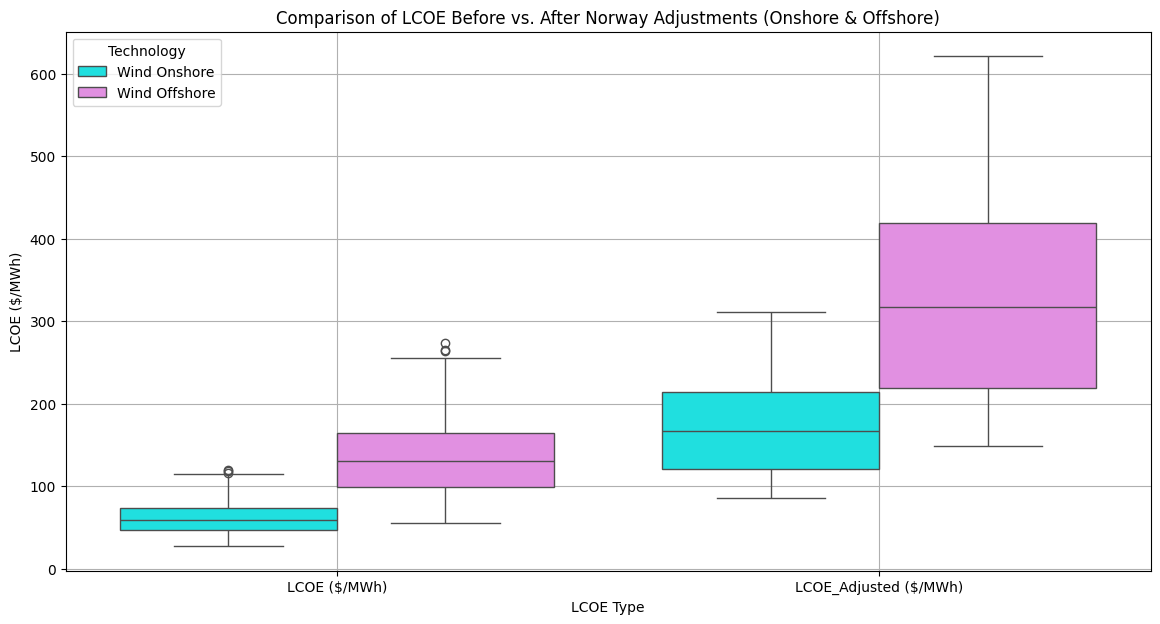

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Reload the adjusted LCOE dataset
file_path = r"C:\Users\SANDEEP SAHU\Documents\Norway_LCOE_Adjusted_Distribution.csv"
df_norway = pd.read_csv(file_path)

print(" Reloaded adjusted LCOE dataset successfully!")

# Step 2: Visualization - LCOE Before vs. After Norway Adjustments (Boxplot & Histogram with Four Colors)
plt.figure(figsize=(14, 7))

sns.boxplot(data=df_norway.melt(id_vars=["Technology"], value_vars=["LCOE ($/MWh)", "LCOE_Adjusted ($/MWh)"]),
            x="variable", y="value", hue="Technology", palette={"Wind Onshore": "cyan", "Wind Offshore": "violet",
                                                                "LCOE_Adjusted ($/MWh) - Wind Onshore": "violet", 
                                                                "LCOE_Adjusted ($/MWh) - Wind Offshore": "red"})

plt.title("Comparison of LCOE Before vs. After Norway Adjustments (Onshore & Offshore)")
plt.xlabel("LCOE Type")
plt.ylabel("LCOE ($/MWh)")
plt.legend(title="Technology")
plt.grid(True)
plt.show()


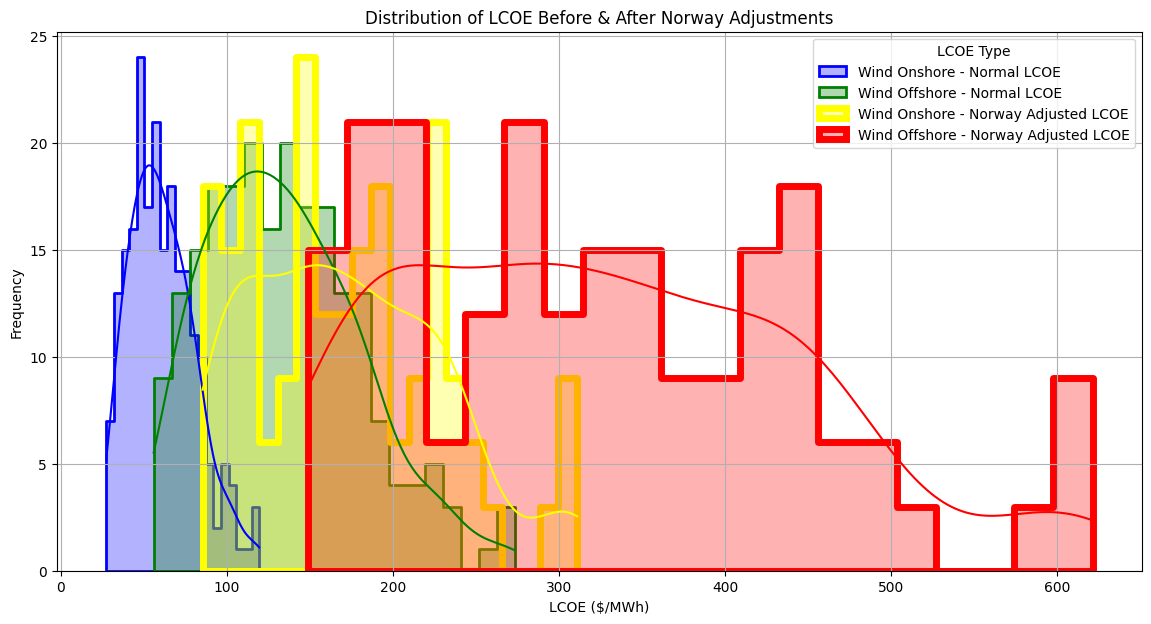

In [21]:
# Step 5: Updated Visualization with Four Different Colors for Normal & Adjusted LCOE

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the dataset is loaded
# Step 1: Reload the adjusted LCOE dataset
file_path = r"C:\Users\SANDEEP SAHU\Documents\Norway_LCOE_Adjusted_Distribution.csv"
df_norway = pd.read_csv(file_path)

# Visualization 2: LCOE Before vs. After Norway Adjustments (Histogram Distribution with Four Colors)
plt.figure(figsize=(14, 7))

# Normal LCOE (Before Adjustment)
sns.histplot(df_norway[df_norway["Technology"] == "Wind Onshore"], x="LCOE ($/MWh)", bins=20, kde=True,
             label="Wind Onshore - Normal LCOE", alpha=0.3, color="blue", element="step", linewidth=2)
sns.histplot(df_norway[df_norway["Technology"] == "Wind Offshore"], x="LCOE ($/MWh)", bins=20, kde=True,
             label="Wind Offshore - Normal LCOE", alpha=0.3, color="green", element="step", linewidth=2)

# Adjusted LCOE (After Norway Adjustments)
sns.histplot(df_norway[df_norway["Technology"] == "Wind Onshore"], x="LCOE_Adjusted ($/MWh)", bins=20, kde=True,
             label="Wind Onshore - Norway Adjusted LCOE", alpha=0.3, color="yellow", element="step", linewidth=5)
sns.histplot(df_norway[df_norway["Technology"] == "Wind Offshore"], x="LCOE_Adjusted ($/MWh)", bins=20, kde=True,
             label="Wind Offshore - Norway Adjusted LCOE", alpha=0.3, color="red", element="step", linewidth=5)

plt.title("Distribution of LCOE Before & After Norway Adjustments")
plt.xlabel("LCOE ($/MWh)")
plt.ylabel("Frequency")
plt.legend(title="LCOE Type")
plt.grid(True)
plt.show()
